In [202]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import joblib
from tqdm import tqdm
import copy
import re
import ast
import os

In [257]:
idx2 = 1
S2 = 1
duration_list = []
loudness_list = []
nuclei_hit_list = ['AA']
def findmin(a, b):
    if(a <= b):
        return a
    return b
def feature_extract(audio_path, syllables, nuclei, mode='train'):
    # syllables = [(s1, start, end), (s2, start, end), ..., (sn, start, end)]
    # nuclei = [(n1, start, end), (n2, start, end), ..., (nn, start, end)]
    global idx2
    global S2
    global nuclei_hit_list
    global duration_list
    global loudness_list
    if(mode == 'test'):
        path = 'wavFullAudio/'
    else:
        path = 'ljs/LJSpeech-1.1/wavs/'
    features = []
    for i in range(len(syllables)):

        syllable = syllables[i]
        nuclei_sym, nuclei_start, nuclei_end = nuclei[i][0], nuclei[i][1], nuclei[i][2]

        # Duration
        y, sr = librosa.load(path + audio_path, sr=None)
        # print("Sr: ", sr)
        start_sample = int(syllable[1] * sr)
        end_sample = int(syllable[2] * sr)
        start_sample_nuclei = int(nuclei_start * sr)
        end_sample_nuclei = int(nuclei_end * sr)
        audio_segment = y[start_sample:end_sample]
        audio_nuclei = y[start_sample_nuclei:end_sample_nuclei]
        duration = syllable[2] - syllable[1]
        nuclei_duration = nuclei_end - nuclei_start
        if(nuclei_sym in nuclei_hit_list):
            duration_list.append(nuclei_duration)

        # Loudness
        rms = np.sqrt(np.mean(audio_segment**2))
        peak_intensity = np.max(np.abs(audio_segment))
        mean_intensity = np.mean(np.abs(audio_segment))

        rms_nuclei = np.sqrt(np.mean(audio_nuclei**2))
        peak_intensity_nuclei = np.max(np.abs(audio_nuclei))
        mean_intensity_nuclei = np.mean(np.abs(audio_nuclei))
        if(nuclei_sym in nuclei_hit_list):
            loudness_list.append(mean_intensity_nuclei)

        # print(len(audio_segment))

        # Pitch
        fmin = 50
        fmax = 400
        f0, voiced_flag, voiced_probs = librosa.pyin(
            audio_segment, fmin=fmin, fmax=fmax
        )
        f0_voiced = f0[~np.isnan(f0)]
        peak_f0 = np.max(f0_voiced) if len(f0_voiced) > 0 else 0
        mean_f0 = np.mean(f0_voiced) if len(f0_voiced) > 0 else 0
        f0_st = librosa.hz_to_midi(f0_voiced)
        # Spectral
        mfccs = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=13)

        S = np.abs(librosa.stft(audio_segment, n_fft=2048))**2

        frequencies = librosa.fft_frequencies(sr=sr, n_fft=2048)

        bands = [(500, 1000), (1000, 2000), (2000, 4000)]
        mean_intensities = []

        for low, high in bands:
            idx = np.where((frequencies >= low) & (frequencies <= high))[0]
            idx2 = copy.deepcopy(idx)
            S2 = copy.deepcopy(S)
            if(idx is not None):
                band_power = S[idx, :].mean()
            else:
                band_power = 0
            mean_intensities.append(band_power)

        features.append([mfcc for mfcc in mfccs.mean(axis = 1)] + [duration, nuclei_duration, rms, peak_intensity, mean_intensity, rms_nuclei, peak_intensity_nuclei, mean_intensity_nuclei, peak_f0, mean_f0, mean_intensities[0], mean_intensities[1], mean_intensities[2]])
    return features, sr
    

In [258]:
def extract_features(train_data, mode='train'):
    X_train = []
    Y_train = []
    if(mode == 'test'):
        path = 'wavFullAudio/'
    else:
        path = 'ljs/LJSpeech-1.1/wavs/'

    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    for t in tqdm(train_data):
        audio_path, syllable_sequences, nuclei_sequences, y_sequence = t
        if(audio_path in files):
            temp, sr = feature_extract(audio_path, syllable_sequences, nuclei_sequences, mode)
            X_train += temp
            Y_train += y_sequence
    return X_train, Y_train

In [38]:
x = joblib.load('data.pkl')
temp = []
for elem in x:
    if(elem[3] != []):
        temp.append(elem)
x = temp

In [233]:
with open("SYLLABLESTRESS2", "r") as f:
    data = f.readlines()
for i in range(len(data)):
    data[i] = data[i][:-1]

In [234]:
data[0]

'"ISLE_SESS0003_BLOCKD01_01_sprt1.wav", [(\'AY\', 0.14, 0.2), (\'S EH D\', 0.2, 0.47), (\'W AY T\', 0.47, 0.99), (\'N AO T\', 0.99, 1.19), (\'B EY T S\', 1.19, 1.69)], [(\'AY\', 0.14, 0.2), (\'EH\', 0.32, 0.38), (\'AY\', 0.61, 0.9), (\'AO\', 1.07, 1.15), (\'EY\', 1.25, 1.5)], [1, 1, 1, 1, 1]'

In [235]:
# Regular expression to split on top-level commas
split_pattern = r',(?=(?:[^\[\]]|\[[^\[\]]*\])*$)'
x_test = []

for i in tqdm(range(len(data))):
# Splitting the line
    parts = re.split(split_pattern, data[i])

    # Trim whitespace around each part
    parts = [part.strip() for part in parts]

    syllables = ast.literal_eval(parts[1])
    nuclei = ast.literal_eval(parts[2])
    y_sequence = ast.literal_eval(parts[3])

    syllables = [(item[0], float(item[1]), float(item[2])) for item in syllables]
    nuclei = [(item[0], float(item[1]), float(item[2])) for item in nuclei]
    y_sequence = [int(item) for item in y_sequence]

    x_test.append((parts[0][1:-1], syllables, nuclei, y_sequence))

100%|██████████| 222/222 [00:00<00:00, 4532.55it/s]


In [159]:
# Convert the string to a list of tuples with numbers as floats

# Safely parse the string to a Python object
parsed_list = ast.literal_eval(parts[1])
# Ensure all numbers are converted to floats
result = [(item[0], float(item[1]), float(item[2])) for item in parsed_list]

# Output the result
print(result)


[('AY', 0.14, 0.2), ('S EH D', 0.2, 0.47), ('W AY T', 0.47, 0.99), ('N AO T', 0.99, 1.19), ('B EY T S', 1.19, 1.69)]


In [39]:
len(x)

222366

In [40]:
j = 0
for i in range(len(x)):
    if(len(x[i][1]) != len(x[i][2])):
        print(x[i][0])

In [68]:
features, sr = feature_extract("outside.wav", [('s1', 1, 2), ('s2', 3, 4.5)], [('AO', 1.5, 1.7), ('AA', 3.2, 3.7)])

In [98]:
X_train, Y_train = extract_features([
    ("outside.wav", [('s1', 1, 2), ('s2', 3, 4.5)], [('AO', 1.5, 1.7), ('AA', 3.2, 3.7)], [0, 1]),
    ("outside.wav", [('s1', 1, 1.5), ('s2', 3, 4)], [('AA', 1.3, 1.4), ('AA', 3.2, 3.7)], [0, 1]),
    ("cat.wav", [('s1', 1, 1.5), ('s2', 2, 2.5)], [('AO', 1.2, 1.27), ('AA', 2.1, 2.4)], [1, 1]),
    ("cat.wav", [('s1', 1.2, 1.5), ('s2', 2, 2.5)], [('AO', 1.2, 1.3), ('AA', 2.1, 2.4)], [1, 1]),
    ("pt.wav", [('s1', 1, 2), ('s2', 3, 4), ('s3', 4.2, 4.5)], [('AO', 1.5, 1.7), ('AA', 3.2, 3.7), ('AI', 4.3, 4.4)], [1, 0, 1]),
    ("pt.wav", [('s1', 1, 1.5), ('s2', 3, 4)], [('AA', 1.3, 1.4), ('AA', 3.2, 3.7)], [1, 0]),
])

In [222]:
duration = []
for i in tqdm(range(len(x))):
    nuclei = x[i][2]
    for nucleus in nuclei:
        if(nucleus[0] == 'AA'):
            duration.append(nucleus[2] - nucleus[1])

100%|██████████| 222366/222366 [00:00<00:00, 2010915.39it/s]


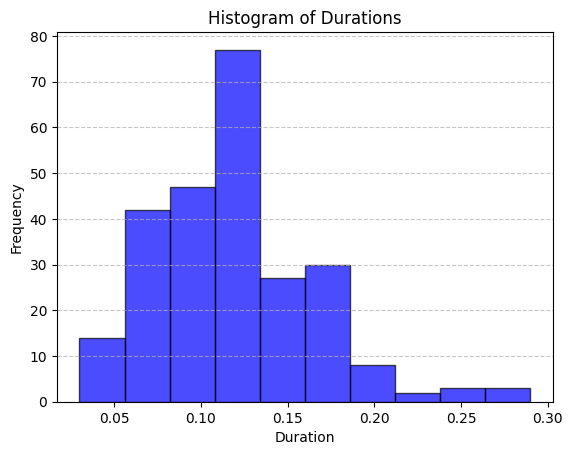

In [231]:
import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist(duration_list, bins=10, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Durations")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


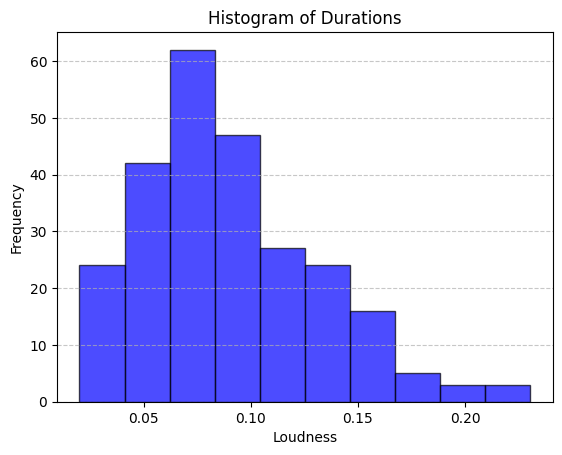

In [232]:
import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist(loudness_list, bins=10, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Durations")
plt.xlabel("Loudness")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


In [259]:
X_train, Y_train = extract_features(x[:5000], 'train')

100%|██████████| 5000/5000 [05:36<00:00, 14.86it/s]


In [243]:
X_test, Y_test = extract_features(x_test, 'test')

100%|██████████| 222/222 [01:12<00:00,  3.04it/s]


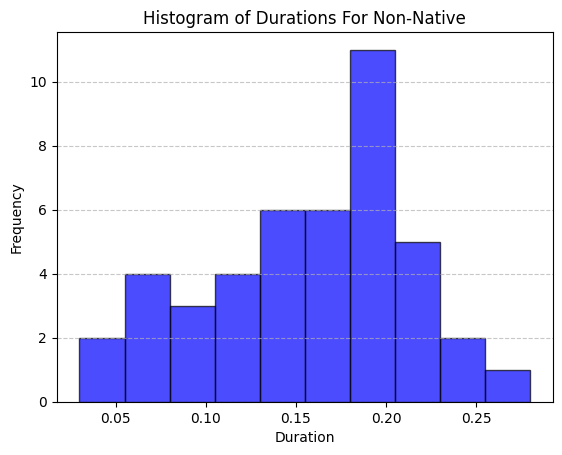

In [238]:
import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist(duration_list, bins=10, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Durations For Non-Native")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


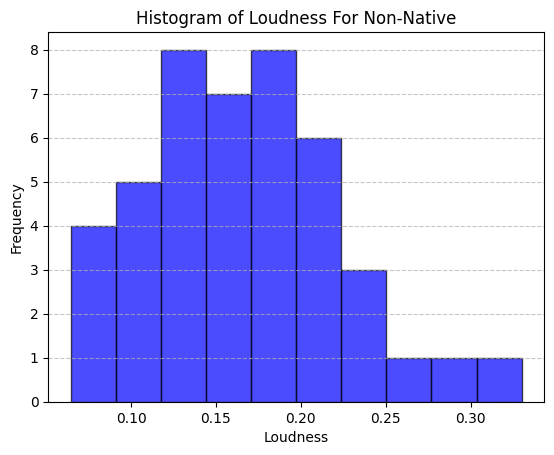

In [239]:
import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist(loudness_list, bins=10, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Loudness For Non-Native")
plt.xlabel("Loudness")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


In [88]:
print(idx2)

[186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368 369 370 371]


In [92]:
print(S2)

[[2.0495224e+00 5.4008061e-01 2.1349664e-05 6.9052413e-02 2.4741377e-01]
 [2.0667589e+00 5.1700926e-01 1.0575798e-03 6.3242197e-02 2.3080912e-01]
 [2.2755151e+00 6.3175488e-01 2.4406377e-03 4.9796581e-02 2.5929457e-01]
 ...
 [5.0390633e-03 1.2676730e-03 4.3639328e-09 1.5834559e-05 6.6311412e-05]
 [5.0403150e-03 1.2673902e-03 5.9204734e-09 1.5636950e-05 6.5804656e-05]
 [5.0426307e-03 1.2739457e-03 1.5457935e-08 1.6857695e-05 6.6437184e-05]]


In [95]:
X_test, Y_test = extract_features([
    ("outside.wav", [('s1', 1, 2), ('s2', 3, 4.5)], [('AO', 1.5, 1.7), ('AA', 3.2, 3.7)], [0, 1]),
    ("outside.wav", [('s1', 1, 1.5), ('s2', 3, 4)], [('AA', 1.3, 1.4), ('AA', 3.2, 3.7)], [0, 1]),
    ("cat.wav", [('s1', 1, 1.5), ('s2', 2, 2.5)], [('AO', 1.2, 1.27), ('AA', 2.1, 2.4)], [1, 1]),
])

In [254]:
X_test, Y_test = extract_features(x[5000:6000])

100%|██████████| 1000/1000 [01:08<00:00, 14.67it/s]


In [124]:
import joblib

In [255]:
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(Y_train, 'Y_train.pkl')

['Y_train.pkl']

In [256]:
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(Y_test, 'Y_test.pkl')

['Y_test.pkl']

In [70]:
len(features[0])

27

In [7]:
features[0][11]

2.8976190476190027

In [41]:
features[0][0]

array([[-329.0764   , -382.02768  , -455.52264  , ..., -474.55716  ,
        -478.28033  , -511.39096  ],
       [ 120.63499  ,  110.253426 ,   79.26467  , ...,   66.96367  ,
          64.38518  ,   58.872757 ],
       [  22.28028  ,   29.85815  ,   41.56883  , ...,   27.767586 ,
          27.785904 ,   22.624361 ],
       ...,
       [   4.0907063,    2.3288732,   -0.7220191, ...,   -2.8769124,
          -5.502631 ,    1.9468248],
       [   6.566765 ,   10.126333 ,   13.889032 , ...,    7.456368 ,
           9.077913 ,   13.691186 ],
       [   3.7939315,    4.0822   ,   11.163702 , ...,   -4.321083 ,
           2.1453552,    4.365468 ]], dtype=float32)

In [194]:
features[0]

(array([[-329.0764   , -382.02768  , -455.52264  , ..., -474.55716  ,
         -478.28033  , -511.39096  ],
        [ 120.63499  ,  110.253426 ,   79.26467  , ...,   66.96367  ,
           64.38518  ,   58.872757 ],
        [  22.28028  ,   29.85815  ,   41.56883  , ...,   27.767586 ,
           27.785904 ,   22.624361 ],
        ...,
        [   4.0907063,    2.3288732,   -0.7220191, ...,   -2.8769124,
           -5.502631 ,    1.9468248],
        [   6.566765 ,   10.126333 ,   13.889032 , ...,    7.456368 ,
            9.077913 ,   13.691186 ],
        [   3.7939315,    4.0822   ,   11.163702 , ...,   -4.321083 ,
            2.1453552,    4.365468 ]], dtype=float32),
 1,
 0.19999999999999996,
 array([0.03524781, 0.04157684, 0.04595817, 0.04203352, 0.03886483,
        0.03602966, 0.03388006, 0.03224403, 0.03174796, 0.03024994,
        0.02869109, 0.02801637, 0.02634163, 0.02717446, 0.02915613,
        0.03035721, 0.03053825, 0.02967657, 0.02797118, 0.02605716,
        0.02603981, 0.02

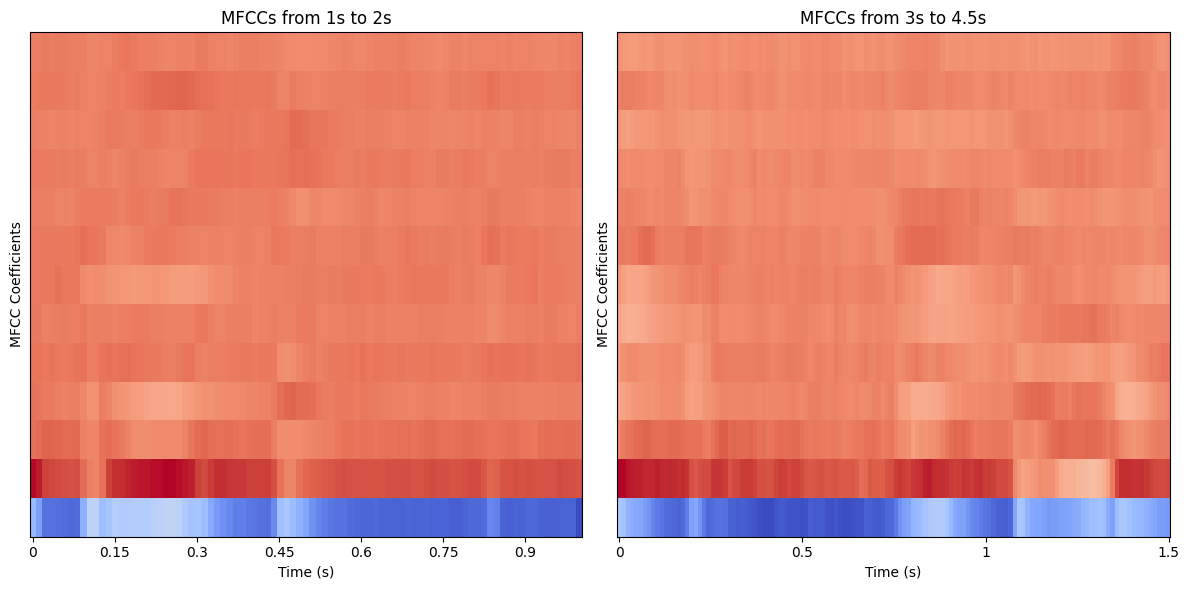

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first MFCC diagram
librosa.display.specshow(features[0][0], x_axis='time', sr=sr, ax=ax[0])
ax[0].set_title(f'MFCCs from {1}s to {2}s')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('MFCC Coefficients')

# Plot the second MFCC diagram
librosa.display.specshow(features[1][0], x_axis='time', sr=sr, ax=ax[1])
ax[1].set_title(f'MFCCs from {3}s to {4.5}s')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('MFCC Coefficients')

# Show the plots
plt.tight_layout()
plt.show()

(13, 81)


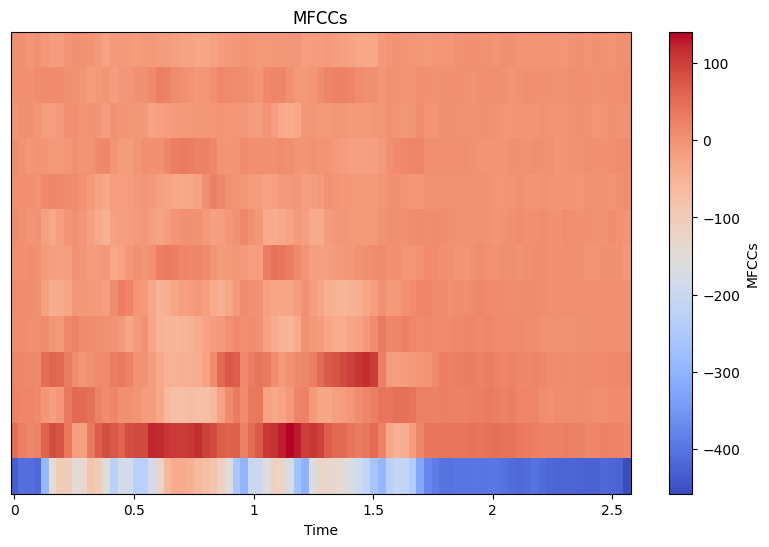

In [119]:
y, sr = librosa.load("wavFullAudio/ISLE_SESS0003_BLOCKD01_01_sprt1.wav", sr=None)

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

print(mfccs.shape)

plt.figure(figsize=(10, 6))  # Set the figure size for the plot
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(label='MFCCs')  # Color bar for better readability
plt.title('MFCCs')  # Title of the plot
plt.show()